# Retrieving data

In [65]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [66]:
# Import the downloaded CSV as a Panda DataFrame
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

# Exploring the data

First, let's get a list of columns and some row counts:

In [67]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


You may have noticed that `ocean_proximity` is a category field. Get a quick count of all the categories in this column

In [68]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

You can also get a quick description of all attributes in the dataset:

In [69]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Or a graphical representation of the columns:

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

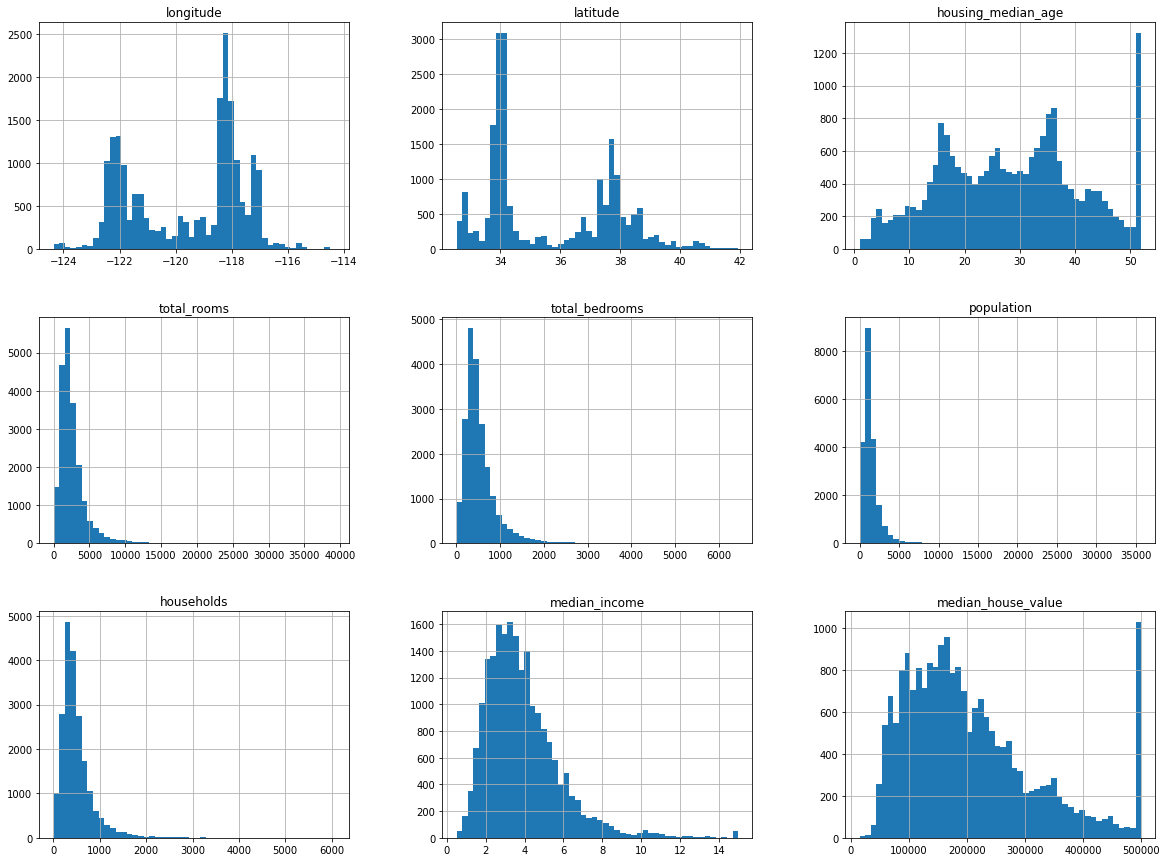

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins = 50, figsize=(20,15))

# Selecting a training and test set

Split the data into 80% training and 20% testing using random sampling

In [71]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Random sampling will give completely different train/test every time. This can change your model wildly between runs. You can make them consistent by seeding the random generator. Another way is to split the dataset by a unique identifier. Latitude and Longitude are pretty good candidates for that.

In [72]:
# Split the dataset into train / test by the hash of an identifier column
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Add an index column to the data set
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16362 train + 4278 test


In [73]:
# Add an id column using the Longtitude and latitude of each district
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print(len(train_set), "train +", len(test_set), "test")

16267 train + 4373 test


Instead of writing our own split functions, we can use those defined in Scikit-Learn

In [74]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


## Sampling Bias

Suppose that an expert tells you that the price of the home one lives in is highly correlated with his/her income. To prevent *sampling bias*, we need to make sure that there's a proportinational number of samples from each income category in both the train and the test set.

<AxesSubplot:>

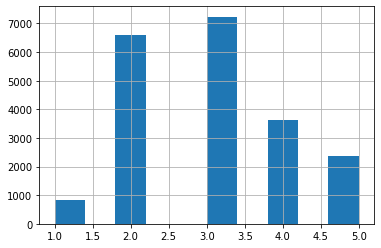

In [75]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

## Stratified data selection

Scikit Learn has a `StratifiedShuffledSplit` function to help with the job

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

You can see that the proporotions of each income stratum in the test set is the same as the population:

array([[<AxesSubplot:title={'center':'income_cat'}>]], dtype=object)

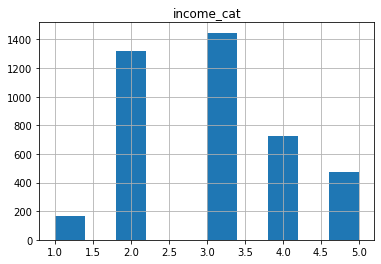

In [77]:
strat_test_set.hist('income_cat')

In [78]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [79]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

# Looking for correlations

Let's make a copy of the train set and explore it before feeding it to a machine learning model:

In [80]:
housing = strat_train_set.copy()
housing.drop("income_cat", axis = 1, inplace = True) # remove this attribute for now

There are 3 secrets in the real estate business "location", "location" and "location" so let's plot them on a map based on their longitude and latitude

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

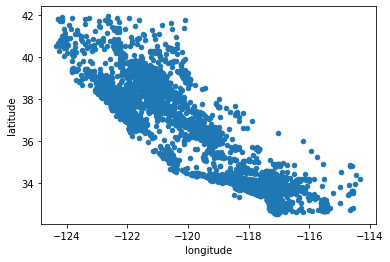

In [81]:
housing.plot(kind="scatter", x="longitude", y="latitude")

And the map looks like the state of California itself! Sometimes raw charts can hide important information. The population density of California is ~97 people per square kilometer. But it's not 97 people per square kilometer everywhere. Los Angeles is far denser than Sierra County for one. It follows that there will be more districts in and around LA. If we reduce the alpha channel, we can see that there's a lot more districts along the coast and the central valley:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

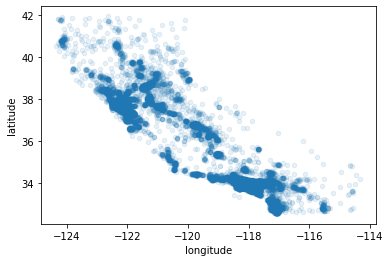

In [82]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Let's add another layer: a heat map of housing value for each district

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

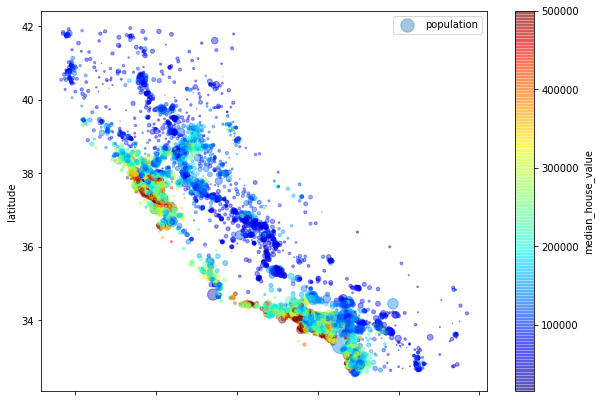

In [83]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

The heatmap tells us that prices are higher along the coast and concentrated in a few big cities. We will confirm that hypothesis quantatively:

In [84]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The house price shows a strong positive correlation with the median income. There's also a weak but noticable negative correlation between house prices and latitude: southern districts tend to be more expensive.

The correlation matrix tells you about *linear correlation*, that is, if `x` goes up, then `y` goes up or down. It does not tell you about *non-linear correlation*, i.e.: if `x` is near 0, `y` generally goes up. Another way is to explore it visually with a scatter matrix plot:

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

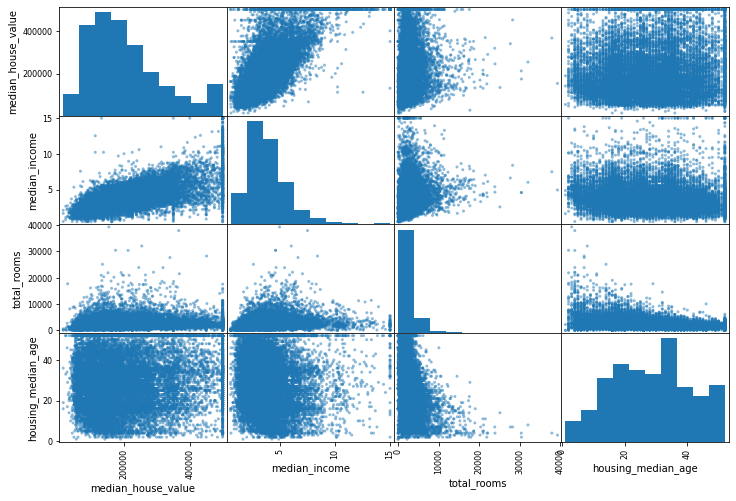

In [85]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

The main diagonal would be full of straight lines if Pandas post each variable against itself. So it displays histograms instead. Other options are available. Strong correlation are indicated by narrow lines. For example `median_house_value` and `median_income` have pretty strong correlation, `median_house_value` and `housing_median_age` do not.

Since `median_income` is a promosing predictor of house value, let's zoom in on that:

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

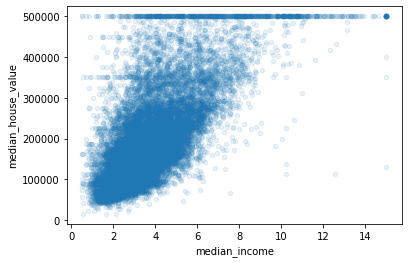

In [86]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things. First the correlation is indeed very strong, as it is a pretty steep line and the points are not too far dispersed. Second, the price cap we noticed earlier is clearly visible as a horizontal line at \\$500k. But the plot also reveals other less obvious lines, such as those near \\$450k and \\$350k. You may want to clean up those data points to prevent your algorithm from reproducing these quirks.

# Experimenting with attribute combination

The previous section hopefully gave you an idea of what your data look like. Some attributes have long tails that you may want to curate a bit, say, by taking their logarithm. One last thing you can experiment with before feeding this to a Machine Learning Algorithm is to experiment with a combination of different attributes. For example, the total number of rooms in a district doesn't convey much information. The *average number of rooms per household* can tell you more.

In [87]:
housing["rooms_per_household"]       = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"]         = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"]  = housing["population"] / housing["households"]

In [88]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

A few insights we can gain:
* A high `bedrooms_per_room` ratio is negatively correlated with house price
* The `rooms_per_household` is a slightly better predictor than `total_rooms` in the district. This makes sense, as more expensive home are usually bigger and have more rooms.

# Prepare the data for Machine Learning Algorithms

In [89]:
# drop labels for training set
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

Some rows in the `total_bedrooms` column contains `nan`. There are 3 ways we can deal with them:
* Drop those rows
* Drop the entire column
* Fill them with sensible placeholder (for example: the median value)

In [90]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
income_cat              0
dtype: int64

SciKit-Learn provides a handy class to take care of missing values: `Imputer`

Since median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute `ocean_proximity`:

In [91]:
from sklearn.impute import SimpleImputer

housing_num = housing.drop(columns='ocean_proximity')

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [92]:
housing_tr.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
income_cat            0
dtype: int64

# Handling text attributes: one-hot encoding

We left out `ocean_proximity` since it's not a number field. Machine leaning frameworks like working with numbers in general. Since it's text, we cannot compute its median.

In [93]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

We can convert it to number using the `factorize` method which maps each category to a different integer:

In [94]:
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [95]:
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [96]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

This causes a problem as the original data clearly has an order (`ISLAND`, `<1H OCEAN`, `NEAR OCEAN`, `NEAR BAY`, `INLAND`) that is not reflected in the numerical codes (4, 0, 1, 3, 2).

One solution is to create one binary attribute per category: one attribute equal to 1 when category is `<1H OCEAN`; another attribute equal to 1 when category is `NEAR OCEAN`; and so on. This is called **one-hot encoding** since only 1 out of 5 attributes will be 1 (hot). The four others will be 0 (cold). The result is a `n x 5` array with each column representing a category:

In [97]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values[:, None])

In [98]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [99]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

# Custom Transformers

Let's create a custom transformer to add extra attributes:

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Feature Scaling

Machine learning algorigthms typically don't do well with input of vastly different scales. For example, the number of rooms go from 6 to 39,320, while the median incomes only range from 0 to 15. Two common ways to get all attributes to have the same scale:

* Min-max scaling (normalization): `scaled value = (raw value - min) / (max - min)`. Scaled value ranges from 0 to 1. Supported by the `MinMaxScaler` in Scikit-Learn

* Standardization: `scaled value = (raw value - mean) / variance`. Does not bound scaled values to a specific range, which can be a problem for certain algorithms, but much less affected by outliers. Supported by `StandardScaler`.

> **Warning:** You should apply the scalers to the training data only. Don't apply it on the full set or the test set.

# Pipeline

## Pipeline 1

As you can see, there are multiple transformations that we must apply on the data. We can collect them into a `Pipeline`:

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

## Pipeline 2

`DataFrameSelector` is a custom transformer that will select only the attributes that we specify (the numerical ones):

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [103]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder())
])

But how can we join the 2 pipelines together? The `FeatureUnion` class takes into a list of pipeline, run them in parallel, and wait for all of them to finish before returning a transformed data frame:

In [104]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

<16512x17 sparse matrix of type '<class 'numpy.float64'>'
	with 214656 stored elements in Compressed Sparse Row format>

# Select and train a model

Let's start with a basic Linear Regression model:

In [105]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

You can run some some prediction tests:

In [106]:
some_data = housing.iloc[:5] # get first 5 rows on the housing frame
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [203682.37484974 326371.3936483  204218.64525713  58685.47455773
 194213.06500272]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works and as expected, the predictions are off (the first one by 40%!). We can measure the entire model's RMSE on the whole training set with the `mean_squared_error` function:

In [107]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

68376.64295459942

To understand the scale of the RSME, let's look at the distribution of housing prices again:

<AxesSubplot:>

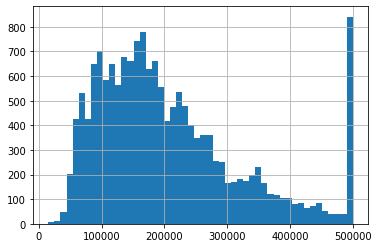

In [108]:
housing_labels.hist(bins=50)

Most districts have home prices under \\$200,000 so an error of \$68,000 is very wide. This is a classic example of the model *underfitting* the training data. It can mean that the features do not provide enough information to the make good predictions, or the model is not powerful enough. The main ways of fixing this are:

* Add more features
* Select a more powerful model
* Reduce the constraints on the model

Since this model is not regularized (i.e. having no constraints at all), option 3 is not possible. We can add more features, but let's try a more complex model first

In [109]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [110]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

No error! So it's perfect? The more likely explanation is the it overfit the training data.

## Cross validation
One way to evaluate the Decision Tree model is use the `train_test_split` function to split the training set into a smaller training set and a validation set. An even better option is to use SKLearn's cross validation feature: it splits the training set into 10 random subsets call *folds*. It then train the model 10 times, picking a different fold for validation and the other 9 for training every time.

> **Warning:** the cross-validation feature expects a *utility* function (greater is better). RMSE is a *distance* function (smaller is better). That's why we take the negative of RMSE below

In [111]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [112]:
def display_scores(scores):
    print("CROSS VALIDATION SCORE")
    print("Scores:", scores)
    print("Mean:", -scores.mean())
    print("Standard Deviation: ", scores.std())

In [113]:
display_scores(tree_rmse_scores)

CROSS VALIDATION SCORE
Scores: [69435.90743413 66320.0515617  70742.71517356 69892.98788738
 71985.06995953 73937.08375376 70299.59162725 71273.503145
 76509.53129092 69886.13220652]
Mean: -71028.25740397579
Standard Deviation:  2595.9550380942937


Now the Decision Tree model doesn't look so good. Its mean error is higher (\\$71,000 $\pm$ 2,800). Cross validation not only give us an estimate of the **performance** (the mean score), but also how **precise** it it (the standard deviation). To compare, let's run a cross validation on the Linear Regression model as well:

In [114]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [115]:
display_scores(lin_rmse_scores)

CROSS VALIDATION SCORE
Scores: [66877.52322114 66608.12023539 70575.91156048 74179.94801427
 67683.32213325 71103.16841292 64782.65897525 67711.29930867
 71080.40483974 67687.6385402 ]
Mean: -68828.99952413201
Standard Deviation:  2662.7615965732252


That's right, the Decision Tree model overfitted so badly that it's performance was worse the Linear Regression model (mean error is higher in the Decision Tree).

Let's try one last model: `RandomForestRegressor`. This model works by training Decision Tree on random subset of the features then averaging out their predictions. Building a model on top of many other models is called *ensemble learning* and is often a great way to push ML algorithm even further.

In [116]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-lin_scores)

In [117]:
forest_rmse

0.0

In [118]:
display_scores(forest_rmse_scores)

CROSS VALIDATION SCORE
Scores: [66877.52322114 66608.12023539 70575.91156048 74179.94801427
 67683.32213325 71103.16841292 64782.65897525 67711.29930867
 71080.40483974 67687.6385402 ]
Mean: -68828.99952413201
Standard Deviation:  2662.7615965732252


This looks better than a single Decision Tree. Forrest Regressor looks very promising, but note that it's still overfitting the training set (`forest_rmse = 0`). Possible solutions for overfitting are:

* Simplify the model
* Constrain (i.e. regularize) it
* Get more training data 

### Experiment with different models
Play around with other models to find the promising candidates (say, up to 5). You can save and load them with the `joblib` function:

```python
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl") # save
my_model = joblib.load("my_model.pkl") # load
```

In [119]:
def test_regressor(regressor):
    regressor.fit(housing_prepared, housing_labels)
    predictions = regressor.predict(housing_prepared)
    scores = cross_val_score(regressor, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    
    mse = mean_squared_error(predictions, housing_labels)
    rmse = np.sqrt(mse)
    print("RMSE =", rmse)
    display_scores(scores)

In [120]:
test_regressor(LinearRegression())

RMSE = 68376.64295459942
CROSS VALIDATION SCORE
Scores: [-4.47260311e+09 -4.43664168e+09 -4.98095929e+09 -5.50266469e+09
 -4.58103209e+09 -5.05566056e+09 -4.19679290e+09 -4.58482005e+09
 -5.05242395e+09 -4.58161641e+09]
Mean: 4744521474.81315
Standard Deviation:  370108493.3899175


In [121]:
test_regressor(DecisionTreeRegressor())

RMSE = 0.0
CROSS VALIDATION SCORE
Scores: [-4.84001590e+09 -4.29925963e+09 -4.84820507e+09 -4.84805740e+09
 -5.05377115e+09 -5.37561067e+09 -4.89207078e+09 -5.14993274e+09
 -5.85095251e+09 -5.01800029e+09]
Mean: 5017587613.273268
Standard Deviation:  382389123.2411582


# Fine-tuning your model

## Grid search
One way to improve the model is to fiddle with the hyperparameters until you find a great combination of hyperparameter values. Use SKLearn's `GridSearchCV` to help you.

* The first dictionary in the `param_grid` array defines $3 \times 4 = 12$ combinations.
* The second dicitonary defines $1 \times 2 \times 3 = 6$ combinations
* `GridSearchCV` will search all 18 combinations to find the best one

> **Tip:** when you have no idea what value for the hyperparameter should have been, a simple approach is to try out consecutive powers of 10 (see `n_estimators` below) or a smaller number (see `max_features`)

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    { 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8] },
    { 'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4] }
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

# Get the combination that give the best score
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

> **Tip:** since 8 and 30 are the max values provided for each hyperparameter, you may want to search again with higher values to see if the score improve. But watch out for overfitting

You can get the best estimator directly:

In [123]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

Or the evaluation scores for every combination

In [124]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64242.550277883485 {'max_features': 2, 'n_estimators': 3}
55760.0510393069 {'max_features': 2, 'n_estimators': 10}
53377.04628998228 {'max_features': 2, 'n_estimators': 30}
60800.241665383815 {'max_features': 4, 'n_estimators': 3}
53703.15862019629 {'max_features': 4, 'n_estimators': 10}
51620.813231999586 {'max_features': 4, 'n_estimators': 30}
60235.31422597745 {'max_features': 6, 'n_estimators': 3}
53360.05543995011 {'max_features': 6, 'n_estimators': 10}
50982.21035700975 {'max_features': 6, 'n_estimators': 30}
59160.713643174095 {'max_features': 8, 'n_estimators': 3}
52454.51825346459 {'max_features': 8, 'n_estimators': 10}
50732.46617281462 {'max_features': 8, 'n_estimators': 30}
62554.56420287415 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54861.1724322918 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60145.41535632755 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53574.86439518136 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

> **Tip:** don't forget that you can treat some data preparation steps as hyperparameters. For example, the grid search will automatically find out whether to add a feature you were not sure about (e.g. using the `add_bedrooms_per_room` hyperparameter of your `CombinedAttributesAdder` transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection and more.

## Randomize Search
The grid approach works if you are exploring a few combinations, but when the search space is large, `RandomizedSeachCV`is often preferable. It evaluates a number of random combinations. You can control the computation budget by specifying how many combinations to try.

## Ensemble search
Another way to fine tune the system is to combine the models that perform best. The group (or *ensemble*) will often perform better than the best individual model - just like Random Forests perform better the Decision Tree &mdash; more in Chapter 7

## Analyze the Best Models and Their Errors
You can often gain good insight by inspecting the best models. For example, `RandomForestRegressor` can indicate the relative importance of each attribute

In [125]:
feature_importance = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_houshold", "pop_per_household", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.311848291730205, 'median_income'),
 (0.15708959553042628, 'income_cat'),
 (0.12346985829162489, 'INLAND'),
 (0.10910795447552758, 'pop_per_household'),
 (0.05894670527016912, 'longitude'),
 (0.05572558989404774, 'latitude'),
 (0.04756102878526418, 'housing_median_age'),
 (0.03336048174545413, 'rooms_per_houshold'),
 (0.027091991778666596, 'bedrooms_per_room'),
 (0.016823233833131918, 'total_bedrooms'),
 (0.016267564943501688, 'population'),
 (0.01603346440650706, 'total_rooms'),
 (0.015991360065329682, 'households'),
 (0.004456995648367666, 'NEAR OCEAN'),
 (0.003877618475328767, '<1H OCEAN'),
 (0.002214698193885577, 'NEAR BAY'),
 (0.0001335669325622188, 'ISLAND')]

Armed with this information, you can drop less useful features, for e.g.: apparently only 1 `ocean_proximity` category is really relevant; you can drop the others.

# Evaluate your system on the test set

In [126]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop(columns="median_house_value")
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

48667.02761512253

# Launch your model
* Write monitoring code to check your system's live performance regularly since models tend to rot over time unless retrained on fresh data
* Evaluate your system performance by sampling the system prediction and evaluating them, which usually requires human analysis
* Monitor input quality - garbage in, garbage out
* Retrain your model regularly to maintain consistent quality. You don't want to see performance degrades for 6 months, then come back up
* Save a snapshot of the estimator everytime so you can quickly rollback

In [127]:
housing_prepared.toarray()

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])